## Spotify Billboard 200 First Impressions

Here we perform an exploratory analysis of the involved features, discuss issues that arise, and run a cross-validated decision tree on the data.

In [47]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
sns.set()
%matplotlib inline

### Cleaning data

Let's start with `acoustic_features.csv`, which contains the panel data for our regression problem, and preview the data

In [3]:
af_raw = pd.read_csv("./data/acoustic_features.csv")
af_raw.head()

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
0,0Veyvc3n9AcLSoK3r1dA12,Voices In My Head,Hoodie SZN,A Boogie Wit da Hoodie,0.0555,0.754,142301.0,0.663,0.000000,6.0,0.101,-6.311,0.0,0.427,90.195,4.0,0.207,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
1,77JzXZonNumWsuXKy9vr3U,Beasty,Hoodie SZN,A Boogie Wit da Hoodie,0.2920,0.860,152829.0,0.418,0.000000,7.0,0.106,-9.061,0.0,0.158,126.023,4.0,0.374,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
2,18yllZD0TdF7ykcREib8Z1,I Did It,Hoodie SZN,A Boogie Wit da Hoodie,0.1530,0.718,215305.0,0.454,0.000046,8.0,0.116,-9.012,1.0,0.127,89.483,4.0,0.196,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
3,1wJRveJZLSb1rjhnUHQiv6,Swervin (feat. 6ix9ine),Hoodie SZN,A Boogie Wit da Hoodie,0.0153,0.581,189487.0,0.662,0.000000,9.0,0.111,-5.239,1.0,0.303,93.023,4.0,0.434,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
4,0jAfdqv18goRTUxm3ilRjb,Startender (feat. Offset and Tyga),Hoodie SZN,A Boogie Wit da Hoodie,0.0235,0.736,192779.0,0.622,0.000000,6.0,0.151,-4.653,0.0,0.133,191.971,4.0,0.506,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21


Let's check out our list of features and the shape of the data, checking for missing data. Recall that we wish to predict `danceability` from the other columns, so all the other columns except for `danceability` are our *features*, while `danceability` is our *response* variable.

In [4]:
X = af_raw.loc[:, af_raw.columns != "danceability"]
y = af_raw["danceability"]
n_features = len(X.columns)
af_raw_shape = af_raw.shape
af_dropna_shape = af_raw.dropna().shape
print("number of features: {0}\nraw shape: {1}\nwithout NA: {2}\ndifference: {3}"
      "".format(n_features, af_raw_shape, af_dropna_shape, af_raw_shape[0] - af_dropna_shape[0]))

number of features: 18
raw shape: (339855, 19)
without NA: (339799, 19)
difference: 56


Ugh, we have missing values. Let's quickly tally how many of the missing values are in each column.

In [5]:
# counts of missing values as a dictionary
mv_counts = {af_raw.columns[i]: 0 for i in range(n_features + 1)}
# isna() and then sum boolean values (true is 1, false is 0)
for i in range(n_features + 1): mv_counts[af_raw.columns[i]] = sum(af_raw[af_raw.columns[i]].isna())
print("{0}".format(mv_counts))

{'id': 0, 'song': 0, 'album': 0, 'artist': 51, 'acousticness': 5, 'danceability': 5, 'duration_ms': 5, 'energy': 5, 'instrumentalness': 5, 'key': 5, 'liveness': 5, 'loudness': 5, 'mode': 5, 'speechiness': 5, 'tempo': 5, 'time_signature': 5, 'valence': 5, 'album_id': 0, 'date': 0}


The majority of the entries with NA values are missing `artist` values. However, for the other missing features, there are exactly 5 missing entries for each. This may be due to recording errors, and we may only have 5 defective rows. We therefore look for rows that are missing just `valence` (could be another one of the features), because if our hypothesis is right, these 5 rows will contain all the other missing features as well.

In [6]:
missing = af_raw.loc[af_raw["valence"].isna(), ]
missing

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
59124,0CTPQF9t7VhbeaadIaXUj4,"Brave Sword, Braver Soul",Rio 2: Music From The Motion Picture,Soundtrack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2UHsd8xIIfzb45usr3n5Sq,2019-03-26
94340,3PfWcsnd0v5JguxWTMzE3F,Group Therapy Intro (ABGT325),Group Therapy,Above & Beyond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5pZqJmRtWYIMRuis7usYMX,2019-04-07
183287,60mTlAJswlhbROAcsaxfsA,"Nocturnes, Op. 9: No. 1, Larghetto in B-Flat M...",Classical Hits,Various Artists,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4ZMu2yKyH4UEqWkmoXz60m,2019-03-30
191991,6XFqSSPw9K6EdZO54QghgG,Split Yo Face,EBK4,Brotha Lynch Hung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57CNgCqpHitXOALuazgeFs,1999-07-13
240050,7Ejk29jo1lKAAQI7UuooAq,We're Gonna Kick It Once,Three The Hard Way,Rodney O & Joe Cooley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4ongwa5RCHuq55GbOmw4WJ,1990-02-22


Clearly, the other 51 rows have all their fields except for the artist field. Let's see why.

In [7]:
no_artist = af_raw.loc[af_raw["artist"].isna(), ]
no_artist.head()

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
241999,6yG67QYhkj9WVIt7WgyHE1,Silhouette,Silhouette,NaN,0.935,0.731,223507.0,0.167,0.000000,6.0,0.1240,-5.990,0.0,0.0297,94.932,4.0,0.274,61vU2oVw8d5QkTNhW8PYla,2018-02-09
334300,0ZUFk0afed2FkqmuJ5zGxR,Shootin' Creek (with The North Carolina Ramblers),Roots Of Country Music (1965),NaN,0.953,0.712,204307.0,0.514,0.004250,5.0,0.0813,-10.511,1.0,0.0391,133.558,4.0,0.923,0jckzrST0anXNTY13KMbSw,2005
334301,5Xhj8u4dAeZYaZwXQJsQ4E,Baltimore Fire (with The North Carolina Ramblers),Roots Of Country Music (1965),NaN,0.901,0.512,191800.0,0.439,0.000001,7.0,0.2220,-8.519,1.0,0.0311,115.861,4.0,0.935,0jckzrST0anXNTY13KMbSw,2005
334302,2bKkPsqxC7o4V2lcwbI18U,Leaving Home (with The North Carolina Ramblers),Roots Of Country Music (1965),NaN,0.988,0.420,189253.0,0.431,0.000314,0.0,0.0653,-10.915,1.0,0.0406,205.555,3.0,0.901,0jckzrST0anXNTY13KMbSw,2005
334303,1hPEhm8zQk4hAyYeD1pHUc,There'll Come a Time (with The North Carolina ...,Roots Of Country Music (1965),NaN,0.961,0.445,209027.0,0.332,0.000000,5.0,0.1340,-11.053,1.0,0.0336,182.993,3.0,0.831,0jckzrST0anXNTY13KMbSw,2005


If one increases the number of rows to show, it seems that the majority of the albums with the missing artist are collections of songs by various artists. Thus, we could replace the NaN in this column with "Various Artists" instead. According to results from a Google Search, the song "Silhouette", from the album *Silhouette*, may be by Kenny G. Since this is only one observation, we can just fill the missing value in and carry on.

In [8]:
af_raw.iloc[241999, 3] = "Kenny G"
af_raw.loc[pd.isna(af_raw["artist"]), af_raw.columns == "artist"] = "Various Artists"
af_raw.loc[af_raw["artist"] == "Various Artists", ].head()

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
3585,4ylWMuGbMXNDgDd8lErEle,The Greatest Show,The Greatest Showman: Reimagined,Various Artists,0.000239,0.417,302147.0,0.824,0.054500,11.0,0.0725,-7.360,0.0,0.1050,157.920,4.0,0.4000,7ayBZIe1FHkNv0T5xFCX6F,2017-12-08
3586,0RoA7ObU6phWpqhlC9zH4Z,A Million Dreams,The Greatest Showman: Reimagined,Various Artists,0.243000,0.265,269453.0,0.312,0.000000,7.0,0.0893,-11.689,1.0,0.0569,54.747,3.0,0.0998,7ayBZIe1FHkNv0T5xFCX6F,2017-12-08
3587,66y7x28jXOPrcmu3D5Zjh6,A Million Dreams (Reprise),The Greatest Showman: Reimagined,Various Artists,0.726000,0.253,60453.0,0.139,0.000050,6.0,0.2690,-17.067,1.0,0.0414,74.369,3.0,0.1020,7ayBZIe1FHkNv0T5xFCX6F,2017-12-08
3588,5xNUR50KxswPRAvx7S163g,Come Alive,The Greatest Showman: Reimagined,Various Artists,0.005580,0.702,225933.0,0.770,0.000802,7.0,0.2110,-9.411,1.0,0.1280,118.034,4.0,0.2350,7ayBZIe1FHkNv0T5xFCX6F,2017-12-08
3589,2cKovq3l6OJjhVVDbVKOsr,The Other Side,The Greatest Showman: Reimagined,Various Artists,0.004330,0.638,214373.0,0.795,0.001390,0.0,0.1530,-8.450,1.0,0.3020,153.990,4.0,0.3100,7ayBZIe1FHkNv0T5xFCX6F,2017-12-08


We check the shape of the DataFrame again, and we are done filling in the missing values that matter. We can discard the 5 entries with no data.

In [9]:
af_dropna_shape = af_raw.dropna().shape
print("number of features: {0}\nraw shape: {1}\nwithout NA: {2}\ndifference: {3}"
      "".format(n_features, af_raw_shape, af_dropna_shape, af_raw_shape[0] - af_dropna_shape[0]))
# amend X and y
X = af_raw.loc[:, af_raw.columns != "danceability"].dropna().copy()
y = af_raw["danceability"].dropna().copy()
print("X shape: {0}\ty shape: {1}".format(X.shape, y.shape))

number of features: 18
raw shape: (339855, 19)
without NA: (339850, 19)
difference: 5
X shape: (339850, 18)	y shape: (339850,)


Now that we have finished handling our missing data, we can get to the actual exploratory feature analysis.

### Feature exploration: what makes the charts?

From the Spotify API documentation for getting audio features from a track [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/), we already have some of our initial exploratory analysis. Refer to the link for descriptions of all the features; we are lucky in that many of the features are calculated values that have well defined ranges. For example, `danceability` itself in on $ [0, \, 1] $, and so are the features `acousticness`, `energy`, `instrumentalness`, `liveness`, `speechiness`, and `valence`.


From the pictures below, we can already see that generally popular songs are **not** acoustic in nature, i.e. most values in `acousticness` are close to 0, although there is variation. `danceability` itself seems to be negatively skewed but with a mean above 0.5, while `energy` is denser on the upper end of the $ [0, \, 1] $ interval. `instrumentalness` markedly shows that the vast majority of popular Billboard 200 songs are not instrumental. Most of the tracks are not performed live; i.e. `liveness` is clustered in the low end with a long upward tail. Also, the vast majority of tracks are **not** speechy; i.e. `speechiness` is typically low and so most songs are musical. Interestingly, `valence` is more or less symmetric, forming a hump distribution; we see that more songs inbetween "happy" or "sad" are popular, but so are many "happy" or "sad" songs.

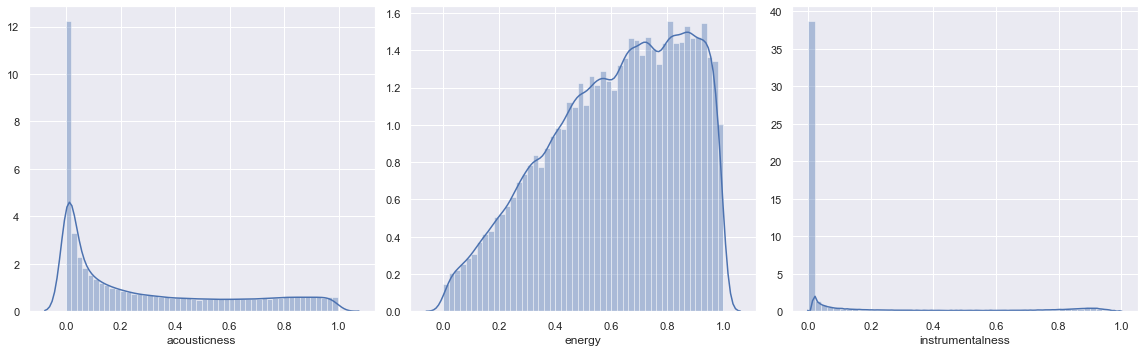

In [10]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
scols = ["acousticness", "energy", "instrumentalness"]
for scol, ax in zip(scols, axs): sns.distplot(X[scol], kde = True, ax = ax)
# prevent graphs from being squished
fig.tight_layout()

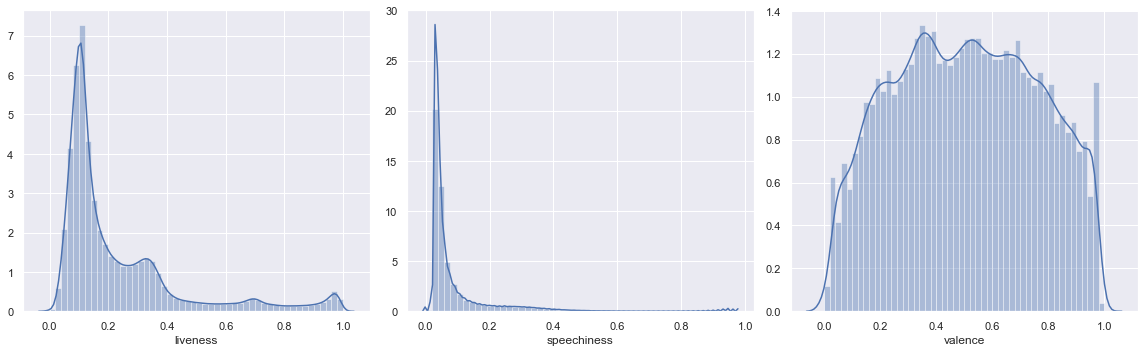

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
scols = ["liveness", "speechiness", "valence"]
for scol, ax in zip(scols, axs): sns.distplot(X[scol], kde = True, ax = ax)
fig.tight_layout()

We can perform some analysis on the non-standardized features now, which include `key`, `mode`, `time_signature`, `loudness`, `tempo`, `duration_ms`, and `date`. `date` we will treat specially, so we put that aside for now. We make some histograms below for the continuous features `loudness`, `duration_ms`, and `tempo`. `key` is categorical [pitch class](https://en.wikipedia.org/wiki/Pitch_class), `mode` is binary 0 (minor), 1 (major), and `time_signature` indicates beats in a bar.

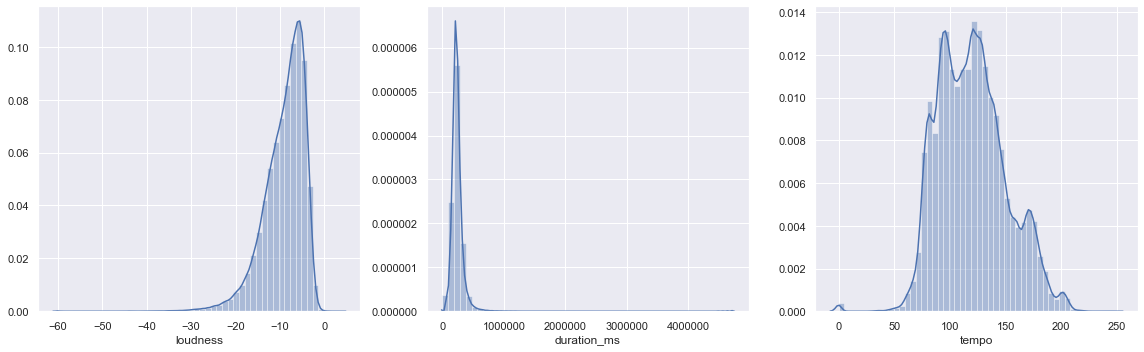

In [12]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
cols = ["loudness", "duration_ms", "tempo"]
for col, ax in zip(cols, axs): sns.distplot(X[col], kde = True, ax = ax)
fig.tight_layout()

We can also calculate some statistics for these features to get a better sense of what they are like beyond visual inspection.

In [13]:
for col in cols:
    print("{0}: {1}".format(col, {"mean": X[col].mean(), "std": X[col].std(), "skew": sps.skew(X[col])}))

loudness: {'mean': -9.07275937619538, 'std': 4.601031677300458, 'skew': -1.4151758598479278}
duration_ms: {'mean': 236735.11662203915, 'std': 102255.71349454521, 'skew': 6.483528429896756}
tempo: {'mean': 119.9339735530381, 'std': 30.380898639898025, 'skew': 0.3284185006641375}


Note that `skew < 0` indicates a heavier left tail, while `skew > 0` indicates a heavier right tail. We now proceed to create bar charts using `countplot` for categorical features `key`, `mode`, and `time_signature`, which we have below.

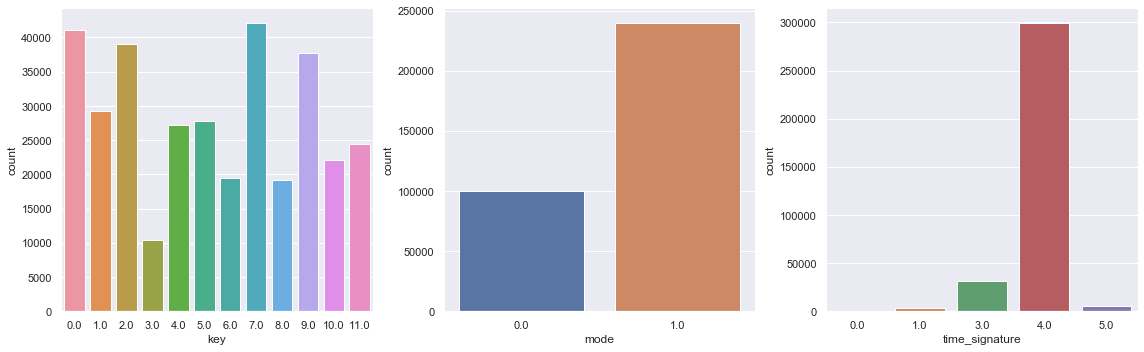

In [14]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
cols = ["key", "mode", "time_signature"]
for col, ax in zip(cols, axs): sns.countplot(X[col], ax = ax)
fig.tight_layout()

One can see that the keys are mixed in distribution. From looking at the pitch classes [here](https://en.wikipedia.org/wiki/Pitch_class), we see that there are higher frequencies of songs in the C (0), D (2), G (7), and A (9) keys. In general, as expected, more songs are of the major key, as in seen from the graph of `mode`. This leads us to believe that the `mode` feature is probably more informative than the exact key 0f the song. Also as expected, `time_signature` is mostly 4 beats per measure, with some 3 beats per measure. However, there appear to be instances where there are 0 beats per measure. Let's see:

In [15]:
zero_beats = X.loc[X["time_signature"] == 0, ]
zero_beats.head()

,id,song,album,artist,acousticness,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
114,7A5uLkZbEOzHiAlhD2Hr2L,"First Stop, Arizona - Dialogue",A Star Is Born (Soundtrack),Lady Gaga & Bradley Cooper,0.878,10760.0,0.2300,0.0000,6.0,0.194,-23.413,1.0,0.0,0.0,0.0,0.0,4sLtOBOzn4s3GDUv3c5oJD,2018-10-05
120,1UR9zquKVw87PBAl5b9PDH,How Do You Hear It? - Dialogue,A Star Is Born (Soundtrack),Lady Gaga & Bradley Cooper,0.606,14507.0,0.1300,0.0000,9.0,0.355,-21.347,1.0,0.0,0.0,0.0,0.0,4sLtOBOzn4s3GDUv3c5oJD,2018-10-05
127,2YEslbHiO4TyqNv2BQ2EWJ,SNL - Dialogue,A Star Is Born (Soundtrack),Lady Gaga & Bradley Cooper,0.408,13147.0,0.0604,0.0000,6.0,0.509,-20.782,1.0,0.0,0.0,0.0,0.0,4sLtOBOzn4s3GDUv3c5oJD,2018-10-05
508,439gEXy3QO4CwMA2Fd8yDS,Emotion,Ella Mai,Ella Mai,0.565,11969.0,0.2580,0.0000,3.0,0.109,-11.957,0.0,0.0,0.0,0.0,0.0,67ErXRS9s9pVG8JmFbrdJ0,2018-10-12
3370,2fiedSmEBdaJcqiOO9DoBG,Michael's Christmas Greeting (Hidden Track) - ...,Christmas,Michael Buble,0.630,3947.0,0.0340,0.0149,1.0,0.000,-20.736,0.0,0.0,0.0,0.0,0.0,7uVimUILdzSZG4KKKWToq0,2012-11-09


I think it is pretty clear these songs have more than zero beats per measure. We check that there are 649 entries with 0 beats per measure.

In [16]:
zero_beats.shape

(649, 18)

### Feature exploration: variation with `danceability`

Now that we have thoroughly looked at all our features, and have a good idea of their distribution and how informative they might be for a Billboard Top 200 song, let's standardize our continuous features to remove scaling issues and see how `danceability` varies with each of the continuous features.

**Remark.** Each one of these cells takes close to 20 seconds to run, as there is a lot of data.

In [17]:
ccols = ["acousticness", "duration_ms", "energy", "instrumentalness", "liveness", "loudness",
         "speechiness", "tempo", "valence"]
sscl = StandardScaler()
Xs_cont = pd.DataFrame(sscl.fit_transform(X[ccols]), columns = ccols)
Xs_cont.head()

,acousticness,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,-0.771097,-0.923511,0.189653,-0.406136,-0.615265,0.600249,2.594201,-0.978872,-1.181590
1,-0.021569,-0.820553,-0.814268,-0.406136,-0.592036,0.002556,0.507205,0.200423,-0.522012
2,-0.462095,-0.209574,-0.666753,-0.405946,-0.545580,0.013206,0.266696,-1.002308,-1.225035
3,-0.898500,-0.462059,0.185556,-0.406136,-0.568808,0.833240,1.632166,-0.885787,-0.285038
4,-0.872513,-0.429865,0.021650,-0.406136,-0.382983,0.960603,0.313246,2.371132,-0.000669


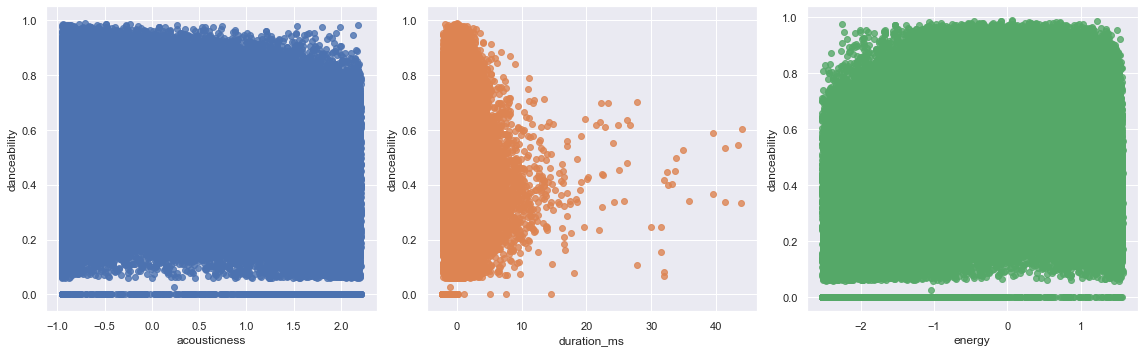

In [18]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
cols = ccols[0:3]
for col, ax in zip(cols, axs): sns.regplot(Xs_cont[col], y, ax = ax, ci = None, fit_reg = False)
fig.tight_layout()

Hm, these features don't seem to be too useful for predicting variation with danceability individually, at least on first glance.

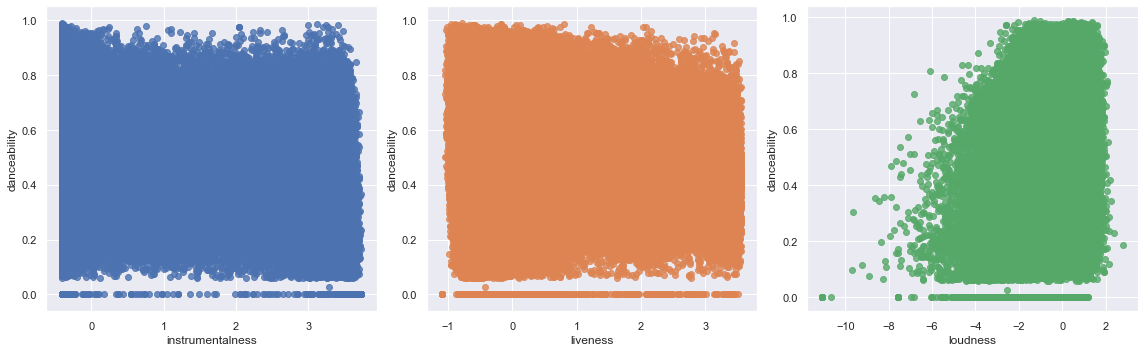

In [19]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
cols = ccols[3:6]
for col, ax in zip(cols, axs): sns.regplot(Xs_cont[col], y, ax = ax, ci = None, fit_reg = False)
fig.tight_layout()

The `loudness` feature shows some more promise than the other two above, but still not great individual variation with `danceability`.

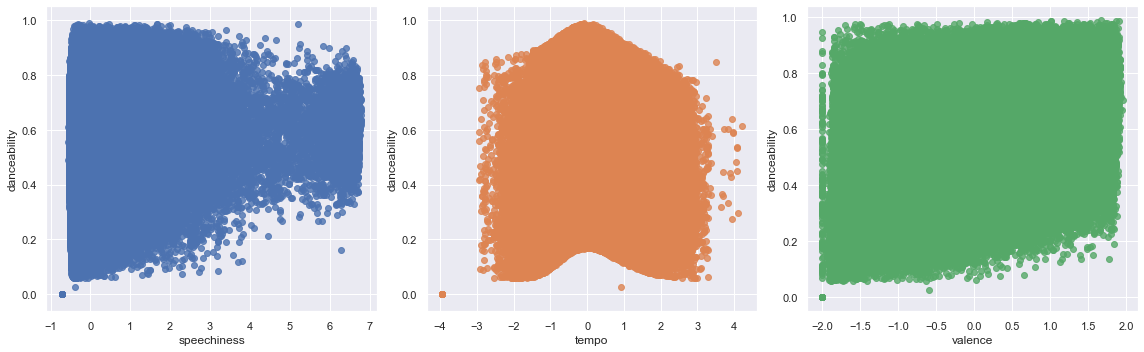

In [20]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
cols = ccols[6:]
for col, ax in zip(cols, axs): sns.regplot(Xs_cont[col], y, ax = ax, ci = None, fit_reg = False)
fig.tight_layout()

`speechiness` seems to show that the higher the speechiness, the more danceable the song is on average. `valence` also shows a bit of a positive correlation as well. `tempo` is interesting, as the central hump matches our intuition that for a song to be danceable to, it can't be too fast or too slow.

### Feature engineering: classification now?

From seeing how `danceability` varies individually with the continuous features, we are not too encouraged. Let's try classification instead by means of a `danceability` threshold $ \eta \in (0, \, 1) $ to create a binary separation of classes. Let's define a function of `danceability` $ Y_{\eta} : [0, \, 1] \rightarrow \{0, \, 1\} $ such that

$$ Y_{\eta}(x) = \mathbf{1}_{\{\eta < x \le 1\}} $$

Let's create our new feature, initially setting $ \eta $ to be 0.5.

In [21]:
eta = 0.5
# need to carry over y's original index because some rows were dropped
ystar = pd.DataFrame(map(lambda x: 1 if x > eta else 0, y), columns = ["danceable"], index = y.index)
ystar.head()

,danceable
0,1
1,1
2,1
3,1
4,1


Let's check the target class distribution to see the relative frequencies of $ Y_\eta $ values.

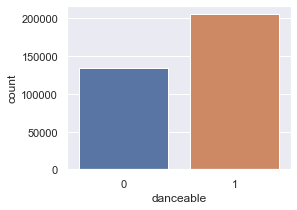

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 3))
sns.countplot(ystar["danceable"], ax = ax)

Let's see if being `danceable` is linearly separable by the continuous predictors. I don't think so but we can try.

**Remark.** The following cell takes a while to run since we trying to process all the features at once.

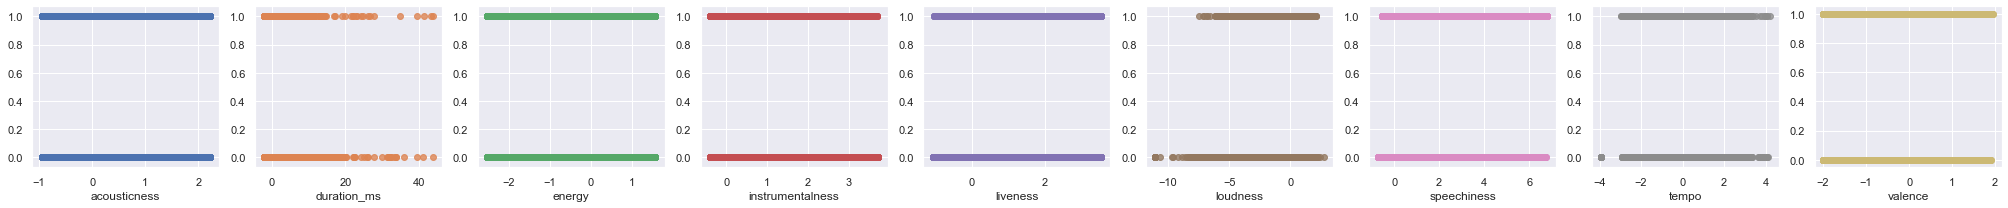

In [23]:
fig, axs = plt.subplots(nrows = 1, ncols = 9, figsize = (28, 3))
cols = ccols
for col, ax in zip(cols, axs): sns.regplot(Xs_cont[col], ystar, ax = ax, ci = None, fit_reg = False)
fig.tight_layout()

Looks like the continuous features don't really show any obvious linear separation of `danceable`. Let's check how the categorical features relate to $ Y_\eta $.

First for the rows where $ Y_\eta = 1 $:

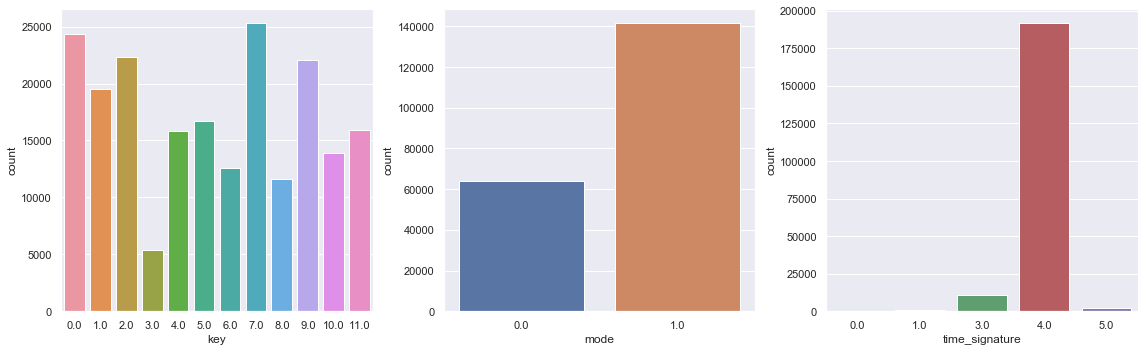

In [24]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
cols = ["key", "mode", "time_signature"]
for col, ax in zip(cols, axs): sns.countplot(X.loc[ystar["danceable"] == 1, X.columns == col][col], ax = ax)
fig.tight_layout()

Then for the rows where $ Y_\eta = 0 $:

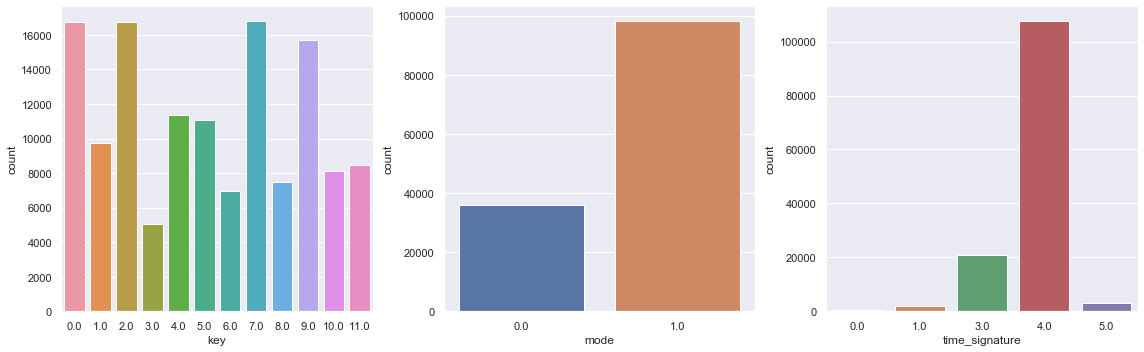

In [25]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
cols = ["key", "mode", "time_signature"]
for col, ax in zip(cols, axs): sns.countplot(X.loc[ystar["danceable"] == 0, X.columns == col][col], ax = ax)
fig.tight_layout()

These distributions don't seem to be markedly different, so perhaps the categorical features will not be super useful either. But before we give up, let's try to fit a model to the features and see what happens. We will try a simple decision tree implementation to try and predict $ Y_\eta $, keeping $ \eta = 0.5 $.

### Single CV decision tree

We will opt to use a 5-fold cross validated tree, with exhaustive parameter search. I have 4 cores on this machine, so I will use 2 of them for this task.

First we get dummies for `key`, `mode`, and `time_signature`.

In [26]:
# we ignore mode since mode is 1 for major, 0 for minor
cat_cols = ["key", "time_signature"]
# get dummies for each of the columns; need to map to string to be treated as categorical
X_cat = None
for cc in cat_cols:
    ccat = pd.get_dummies(pd.DataFrame(map(lambda x: str(int(x)), X[cc]), columns = [cc]), prefix = cc[:3])
    if X_cat is None: X_cat = ccat
    else: X_cat = X_cat.merge(ccat, how = "outer", left_index = True, right_index = True)
print(X_cat.shape)
X_cat.head()

(339850, 17)


,key_0,key_1,key_10,key_11,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,tim_0,tim_1,tim_3,tim_4,tim_5
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


Now we merge `X_cat` with `Xs_cont` to get our final `Xsf`. We are now ready to start training our model.

In [27]:
Xsf = Xs_cont.merge(X_cat, how = "outer", left_index = True, right_index = True)
print(Xsf.shape)
Xsf.head()

(339850, 26)


,acousticness,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_0,...,key_5,key_6,key_7,key_8,key_9,tim_0,tim_1,tim_3,tim_4,tim_5
0,-0.771097,-0.923511,0.189653,-0.406136,-0.615265,0.600249,2.594201,-0.978872,-1.181590,0,...,0,1,0,0,0,0,0,0,1,0
1,-0.021569,-0.820553,-0.814268,-0.406136,-0.592036,0.002556,0.507205,0.200423,-0.522012,0,...,0,0,1,0,0,0,0,0,1,0
2,-0.462095,-0.209574,-0.666753,-0.405946,-0.545580,0.013206,0.266696,-1.002308,-1.225035,0,...,0,0,0,1,0,0,0,0,1,0
3,-0.898500,-0.462059,0.185556,-0.406136,-0.568808,0.833240,1.632166,-0.885787,-0.285038,0,...,0,0,0,0,1,0,0,0,1,0
4,-0.872513,-0.429865,0.021650,-0.406136,-0.382983,0.960603,0.313246,2.371132,-0.000669,0,...,0,1,0,0,0,0,0,0,1,0


I opt to do an exhaustive grid search over all the features, so no feature elimination for now. 

**Remark.** On my machine, running in parallel with two cores, this takes me about ~5 minutes. Results may vary.

In [28]:
dtc = DecisionTreeClassifier(criterion = "entropy")
param_grid = {"min_samples_split": [2, 10, 20, 40], 
              "max_depth": [25, 50, None], 
              "max_features": ["auto", None]}
# accuracy scoring is good enough for now
dtc_gscv = GridSearchCV(dtc, param_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
# split into train and test for final holdout evaluation (constant random state for test purposes)
Xsf_train, Xsf_test, ystar_train, ystar_test = train_test_split(Xsf, ystar, test_size = 0.2, random_state = 7)
dtc_gscv.fit(Xsf_train, ystar_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:  4.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=2,
             param_grid={'max_depth': [25, 50, None],
                         'max_features': ['auto', None],
                         

We can check the average cross-validated training score (we use accuracy as a metric) and the holdout score of the best tree.

In [29]:
# our best decision tree estimator
dtc_best = dtc_gscv.best_estimator_
print("5-fold CV grid accuracy:\t{0:.5f}\nbest tree grid accuracy:\t{1:.5f}\n"
      "best tree test accuracy:\t{2:.5f}"
      "".format(dtc_gscv.cv_results_["mean_test_score"].mean(), dtc_gscv.best_score_, 
                dtc_best.score(Xsf_test, ystar_test)))
# our best decision tree estimator
dtc_best

5-fold CV grid accuracy:	0.73312
best tree grid accuracy:	0.75224
best tree test accuracy:	0.75286


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=25,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=40,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Well, this is actually not too bad. Consider that before I had run both `LassoCV` and `RidgeCV` on the continuous features only for prediction of $ Y $ (`danceability`; continuous $ [0, \, 1] $ unlike $ Y_\eta $) and had been running with an "out-of-the-box" $ R^2 $ of less than 0.45 for both models. Perhaps this is also due to the fact that we have changed our problem from regression to classification, which intuitively seems "easier" since there are less choices, but then again from inspection there doesn't seem to be too much distinction between individual features and the response variables.

However, the accuracy metric does miss a lot of information. Let's produce a confusion matrix to see what is actually happening.

**Remark.** The new version (3.1.1) of `matplotlib` has broken the `heatmap` plot, so I use 3.1.0.

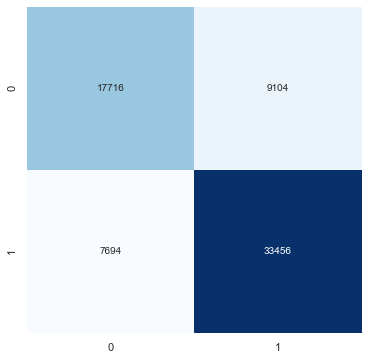

In [38]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 6))
sns.heatmap(confusion_matrix(ystar_test, dtc_best.predict(Xsf_test)), annot = True,
            cmap = "Blues", cbar = False, ax = ax, fmt = "d")

Looks like our model is much more effective at predicting whether $ Y_\eta > \eta $ (danceable) then predicting if $ Y_\eta \le \eta $ (not danceable). It is misclassifying not danceable songs as danceable at a much higher rate than it is misclassifying danceable songs as not danceable. We see that there are less samples of not danceable songs compared to danceable songs in the Billboard 200 data, which may be partially responsible for this phenomenon.

### Next steps

Since it is clear that not danceable songs are being misclassified at a higher rate than danceable songs, and that there are less danceable songs than not danceable songs, maybe we should try using SMOTE to synthetically rebalance the class proportions. We can try tree boosting, using say AdaBoost to penalize misclassifications and create a stronger learner from a set of weak trees like the one above. But all in all, surprising performance.

To celebrate, let's play some upbeat music; after all, this is a music-themed project. Click [here](https://www.youtube.com/watch?v=vTIIMJ9tUc8) for the tune.